## Kaggle Climate Change Belief Challenge

Alta Saunders

# Aim

Develop a machine leraning model that can predict whether people belief in Climate Change based on tweets.

# Supplied Data sets

- train.csv (should be used to train data)
- test.csv (should be used to test data and excludes arrival times)
- example of submission

# Import and viewing of Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [326]:
df_train = pd.read_csv('C:/Users/alta/Documents/GitHub/kaggle/train.csv')
df_test = pd.read_csv('C:/Users/alta/Documents/GitHub/kaggle/test.csv')
df_sub = pd.read_csv('C:/Users/alta/Documents/GitHub/kaggle/sample_submission.csv')

In [332]:
import nltk 
nltk.download('words')
words = set(nltk.corpus.words.words())


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\alta\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


## Dealing with Imbalanced data

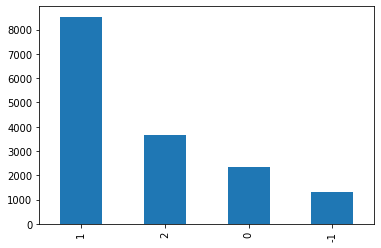

In [337]:
df_train['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

There is a clear disparity in the distribution of the data (2,0,-1 are under represented). Everything needs to be equal before training.

In [338]:
# Indicies of each group
sentiment_0 = df_train[df_train.sentiment == 0]
sentiment_1 = df_train[df_train.sentiment == 1]
sentiment_2 = df_train[df_train.sentiment == 2]
sentiment_n1 = df_train[df_train.sentiment == -1]



In [339]:
# get length of majority sentiment
n_sentimentn1 = len(sentiment_n1)


In [340]:
from sklearn.utils import resample

In [341]:
# downsample majorityclass
sentiment_0_upsampled = resample(sentiment_0, replace=True, n_samples=n_sentimentn1, random_state=50) 
sentiment_1_upsampled = resample(sentiment_1, replace=True, n_samples=n_sentimentn1, random_state=50)
sentiment_2_upsampled = resample(sentiment_2, replace=True, n_samples=n_sentimentn1, random_state=50)
 

In [342]:
#create new upsampled dataframe
df_upsampled = pd.concat([sentiment_0_upsampled, sentiment_1_upsampled,sentiment_2_upsampled, sentiment_n1])

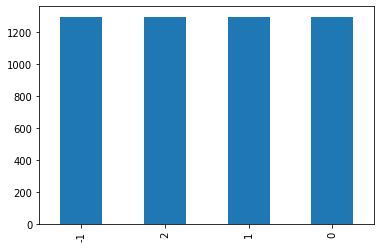

In [343]:
df_upsampled['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

# Preprocessing of data

In [29]:
import nltk
import re

View data to see how to best clean it and remove noise

To clean data we can remove the @.... strings, we can remove punctuation and make everything lower case.

In [349]:
pattern_tweets = r'(RT)|(@[A-Za-z0-9]+)'
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'



In [358]:
tweets = df_upsampled['message']

In [392]:
tweets_clean = []

from string import punctuation
my_punctuation = punctuation.replace("'", "")

for x in tweets:
    new = ' '.join(re.sub(pattern_tweets," ",x).split())
    new1 = ' '.join(re.sub(pattern_url," ",new).split())
    new2 = new1.translate(str.maketrans("", "", my_punctuation))
    new3 = ' '.join(re.sub(r'[^a-zA-Z]', " ",new2).split())
   
    tweets_clean.append(new3)

There are non-english tweets in the training dataset, however there are very few non-english tweets in the test dataset. We do not want to train our model on non-englisg tokens> Lets remove all non-englisjh characters.

In [394]:
tweets_en = []

import nltk
words = set(nltk.corpus.words.words())

for x in tweets_clean:
    new = " ".join(i for i in nltk.wordpunct_tokenize(x) if i.lower() in words or not i.isalpha())
    tweets_en.append(new)


In [395]:
len(tweets_en)

5184

In [396]:
df_upsampled['message'] = tweets_en

In [397]:
#make lower case
df_upsampled['message'] = df_upsampled['message'].str.lower()

## Tokenization

In [398]:
from nltk.tokenize import word_tokenize, TweetTokenizer

In [399]:
tokeniser = TweetTokenizer()
df_upsampled['tokens'] = df_upsampled['message'].apply(tokeniser.tokenize)

In [400]:
df_upsampled['tokens'].head()

11385    [we, re, talking, about, this, story, on, soci...
10030    [yes, and, the, view, will, find, a, way, to, ...
12929    [the, who, are, all, screaming, about, this, a...
14408    [how, can, people, still, try, to, deny, globa...
13470    [is, there, really, a, god, does, global, warm...
Name: tokens, dtype: object

## Vectorize

In [401]:
from sklearn.feature_extraction.text import CountVectorizer

In [408]:
vect = CountVectorizer(stop_words = 'english', ngram_range=(2,3))

In [409]:
X_tokens = vect.fit_transform(df_upsampled['message'])
df_tokens = pd.DataFrame(X_tokens.A, columns=vect.get_feature_names())

In [411]:
df_tokens.to_csv(r'C:/Users/alta/Documents/Explore/Trains/Sprint 6/kaggle/df_tokens.csv', index = False)

In [412]:
col_names_tokens = df_tokens.columns
col_names_tokens

Index(['abandon deal', 'abandon historic', 'abandon historic climate',
       'abide climate', 'abide climate change', 'able destroy',
       'able destroy global', 'abolish education',
       'abolish education teaching', 'abortion choice',
       ...
       'zero gun control', 'zero proof', 'zero science',
       'zero science emotion', 'zero unexpected', 'zero unexpected fight',
       'zone guess', 'zone guess believe', 'zone temperate',
       'zone temperate survive'],
      dtype='object', length=30271)

In [8]:
df_upsampled = pd.read_csv('C:/Users/alta/Documents/Explore/Trains/Sprint 6/kaggle/df_upsampled.csv')

In [413]:
#add sentiment and to dataframe
y = df_upsampled['sentiment']

# Train model

## Split data into train and test data set

In [255]:
df_tokens = pd.read_csv('C:/Users/alta/Documents/Explore/Trains/Sprint 6/kaggle/df_tokens5.csv')

In [256]:
df_tokens.shape

(5184, 5001)

In [414]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_tokens,y)

# Feature Selection

## Threshold variance

In [415]:
# Import the var thresh model and choose a threshold
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()

# Transform (i.e.: run selection on) the training data
X_train_vt = selector.fit_transform(X_train)

In [416]:
X_test_vt = selector.transform(X_test)

In [417]:
X_train_vt.shape

(3888, 24323)

In [418]:
X_test_vt.shape

(1296, 24323)

In [419]:
vt = X_train.loc[:, selector.fit(X_train).get_support()]

## K-best

In [420]:
# Import the feature selector module
from sklearn import feature_selection
from sklearn.feature_selection import f_classif

# Set up selector, choosing score function and number of features to retain
selector_kbest = feature_selection.SelectKBest(score_func=f_classif, k=20)

# Transform (i.e.: run selection on) the training data
X_train_kbest = selector_kbest.fit_transform(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [    3     4     9 ... 30256 30257 30262] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [421]:
# Before generating predictions, we'll need to transform the test data the same way we did the train data
X_test_kbest = selector_kbest.transform(X_test)

In [422]:
X_test_kbest.shape

(1296, 20)

In [423]:
X_train_kbest.shape

(3888, 20)

In [424]:
kbest = selector_kbest.get_support(indices=True)

In [425]:
kbest = X_train.iloc[:, kbest]

## Train model

In [267]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [426]:
#create models

#lr = LogisticRegression(C=0.05, penalty='l1', solver='liblinear', verbose=1) 
#kn = KNeighborsClassifier(5)
#svc_linear = SVC(kernel="linear", C=0.05)
svc = SVC(gamma=1, C=2)
#dtc = DecisionTreeClassifier(max_depth=10)
#rfc = RandomForestClassifier(max_depth=10, n_estimators=10)
#abc = AdaBoostClassifier()

In [427]:
#train model on train data
#lr.fit(X_train, y_train)
#kn.fit(X_train, y_train)
#svc_linear.fit(X_train, y_train)
svc.fit(X_train, y_train)
#dtc.fit(X_train, y_train)
#rfc.fit(X_train, y_train)
#abc.fit(X_train, y_train)

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [428]:
#predict on test data
#lr_pred = lr.predict(X_test)
#kn_pred = kn.predict(X_test)
#svc_linear_pred = svc_linear.predict(X_test)
svc_pred =  svc.predict(X_test)
#dtc_pred = dtc.predict(X_test)
#rfc_pred = rfc.predict(X_test) 
#abc_pred = abc.predict(X_test)

create svc models with variance selecting

In [429]:
svc_kbest = SVC(gamma=1, C=2)
svc_kbest = svc_kbest.fit(X_train_kbest, y_train)
svc_kbest_pred = svc_kbest.predict(X_test_kbest)

In [430]:
svc_vt = SVC(gamma=1, C=2)
svc_vt = svc_vt.fit(X_train_vt, y_train)
svc_vt_pred = svc_vt.predict(X_test_vt)

## Calculate metrics

### F1

In [16]:
from sklearn import metrics

In [431]:
#lr_f1  = metrics.f1_score(y_test, lr_pred, average='micro')
#kn_f1  = metrics.f1_score(y_test, kn_pred, average='micro')
#svc_linear_f1  = metrics.f1_score(y_test, svc_linear_pred, average='micro')
svc_f1  = metrics.f1_score(y_test, svc_pred, average='micro')
#dtc_f1  = metrics.f1_score(y_test, dtc_pred, average='micro')
#rfc_f1  = metrics.f1_score(y_test, rfc_pred, average='micro')
#abc_f1  = metrics.f1_score(y_test, abc_pred, average='micro')

In [432]:
#print('lr: ', lr_f1)
#print('kn: ', kn_f1)
#print('svc_linear: ', svc_linear_f1)
print('svc: ', svc_f1)
#print('dtc: ', dtc_f1)
#print('rfc :', rfc_f1)
#print('abc :', abc_f1)

svc:  0.4984567901234568


In [433]:
svc_f1_vt  = metrics.f1_score(y_test, svc_vt_pred, average='micro')
svc_f1_kbest  = metrics.f1_score(y_test, svc_kbest_pred, average='micro')

In [434]:
print('vt: ', svc_f1_vt)
print('kbest: ', svc_f1_kbest)

vt:  0.49459876543209874
kbest:  0.3549382716049383


## Tune Hyper parameters

In [435]:
from sklearn.model_selection import GridSearchCV

Since SVC model did the best, we will start with the hyper parameter tuning for it

In [932]:
nfolds = 2

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]

param_grid = {
    'C'     : Cs, 
    'gamma' : gammas
    }

grid_SVM = GridSearchCV(SVC(), param_grid, scoring='f1_micro', cv=nfolds)

In [ ]:
grid_SVM.best_params_

Now lets use to new hyperparamers and see if there is an improvement

In [436]:
svc_new = SVC(gamma=1, C=1)

In [437]:
svc_new.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [438]:
svc_new_pred =  svc_new.predict(X_test)

In [439]:
svc_f1_new  = metrics.f1_score(y_test, svc_new_pred, average='micro')
print('svc_new: ', svc_f1_new)

svc_new:  0.4992283950617284


Save model to be used later

In [86]:
import pickle

In [87]:
model_saved_path = 'C:/Users/alta/Documents/Explore/Trains/Sprint 6/kaggle/svc.pkl'

In [88]:
with open(model_saved_path, 'wb') as file: pickle.dump(svc, file)

## Get submission dataframe

In [278]:
df_test = pd.read_csv('C:/Users/alta/Documents/GitHub/kaggle/test.csv')
df_sub = pd.read_csv('C:/Users/alta/Documents/GitHub/kaggle/sample_submission.csv')

In [279]:
tweets_test = df_test['message']

In [280]:
tweets_test_clean = []

from string import punctuation
my_punctuation = punctuation.replace("'", "")

for x in tweets:
    new = ' '.join(re.sub(pattern_tweets," ",x).split())
    new1 = ' '.join(re.sub(pattern_url," ",new).split())
    new2 = new1.translate(str.maketrans("", "", my_punctuation))
    new3 = ' '.join(re.sub(r'[^a-zA-Z]', " ",new2).split())
   
    tweets_test_clean.append(new3)


In [ ]:
tweets_test_en = []

import nltk
words = set(nltk.corpus.words.words())

for x in tweets_test_clean:
    new = " ".join(i for i in nltk.wordpunct_tokenize(x) if i.lower() in words or not i.isalpha())
    tweets_test_en.append(new)

In [281]:
df_test['message'] = tweets_test_en

In [282]:
#make lower case
df_test['message'] = df_test['message'].str.lower()

In [283]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(ngram_range=(4,6), max_features=2000)

X_stem_test = vect.fit_transform(df_test['message'])
df_stem_test = pd.DataFrame(X_stem_test.A, columns=vect.get_feature_names())

In [298]:
col_names_tokens = kbest.columns

In [299]:
name_list = []

for i in df_stem_test.columns:
    if i in col_names_tokens:
        name_list.append(i)

In [300]:
missing = []

for i in col_names_tokens:
    if i not in name_list:
        missing.append(i)

In [301]:
complete_word_list = name_list + missing

In [302]:
len(missing)

1

In [303]:
len(name_list)

19

In [304]:
len(complete_word_list)

20

In [305]:
len(col_names_tokens)

20

In [313]:
new_X = df_stem_test.reindex(columns = complete_word_list, fill_value=0)

In [314]:
len(col_names_tokens)

20

In [315]:
len(new_X.columns)

20

In [316]:
y_pred = svc_kbest.predict(new_X)

In [317]:
svc_final_df = pd.DataFrame()

svc_final_df['tweetid'] = df_test['tweetid']
svc_final_df['sentiment'] = y_pred

In [254]:
svc_final_df.to_csv(r'C:/Users/alta/Documents/Explore/Trains/Sprint 6/kaggle/svc_kaggle_sumbmission.csv', index = False)

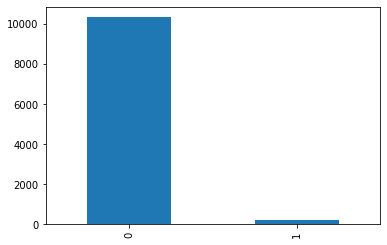

In [318]:
svc_final_df['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

In [324]:
list(df_test['message'])

['europe will now be looking to china to make sure that it is not alone in fighting climate change…',
 "combine this with the polling of staffers re climate change and womens' rights and you have a fascist state",
 'the scary unimpeachable evidence that climate change is already here itstimetochange climatechange ',
 "putin got to you too jill  trump doesn't believe in climate change at all thinks it's s hoax",
 " 'female orgasms cause global warming' sarcastic republican",
 ' trump muzzles employees of several gov’t agencies in effort to suppress info on climate change amp the environment …',
 'yes wrote that in 3rd yr comp sci ethics part was told by climate change denying lecturer that i was wrong amp marked down',
 ' indonesian farmers weather climate change w conservation agriculture  …',
 ' british scientists face a ‘huge hit’ if the us cuts climate change research',
 'aid for agriculture  sustainable agriculture and climate change adaptation for smallscale farmers via',
 'there 